here we found just xarms start level and angle

previous version doesn't work well with strain structures, due to insulators points

In [1]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, LineString

In [2]:
#p = Path(r'/home/igor/Documents/some_tools/structure_samples/xyz')   # for linux
p = Path(r'D:\work\2022_m\training\ok\temp')

In [52]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

10_10_grd.xyz
10_10_str.xyz
11_11_grd.xyz
11_11_str.xyz
12_12_grd.xyz
12_12_str.xyz
13_13_grd.xyz
13_13_str.xyz
14_14_grd.xyz
14_14_str.xyz
15_15_grd.xyz
15_15_str.xyz
16_16_grd.xyz
16_16_str.xyz
17_17_grd.xyz
17_17_str.xyz
18_18_grd.xyz
18_18_str.xyz
19_19_grd.xyz
19_19_str.xyz
1_1_grd.xyz
1_1_str.xyz
20_20_grd.xyz
20_20_str.xyz
21_21_grd.xyz
21_21_str.xyz
22_22_grd.xyz
22_22_str.xyz
23_23_grd.xyz
23_23_str.xyz
24_24_grd.xyz
24_24_str.xyz
25_25_grd.xyz
25_25_str.xyz
2_2_grd.xyz
2_2_str.xyz
3_3_grd.xyz
3_3_str.xyz
4_4_grd.xyz
4_4_str.xyz
5_5_grd.xyz
5_5_str.xyz
6_6_grd.xyz
6_6_str.xyz
7_7_grd.xyz
7_7_str.xyz
8_8_grd.xyz
8_8_str.xyz
9_9_grd.xyz
9_9_str.xyz


In [53]:
from math import sqrt, acos, degrees

def azimuth(a, b):
    # by two points we get azimuth
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dist = round(sqrt(dx*dx + dy*dy), 2)    # dist a to b

    dx2 = round(abs(dx), 2)
    
    if dist != 0:
        beta = degrees(acos(dx2/dist))
    else: 
        beta = degrees(acos(0))

    if dx > 0:
        if dy < 0:
            angle = 270 + beta
        else:
            angle = 270 - beta
    else:
        if dy < 0:
            angle = 90 - beta
        else:
            angle = 90 + beta

    return round(angle, 1), dist

start

In [54]:
spam_file = p / '2_2_str.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[1512631.44, 5365947.59, 69.86],
 [1512631.45, 5365947.42, 70.65],
 [1512631.19, 5365946.89, 70.53],
 [1512631.06, 5365946.44, 71.08],
 [1512631.5, 5365947.34, 71.29]]

In [55]:
# to np array and cut 1/3 from grd
np_str = np.array(str)
np_str_cut = np.delete(np_str, np_str[:,2]<((max(np_str[:,2])-min(np_str[:,2]))/3 + min(np_str[:,2])), 0)

In [56]:
#lets find center 
cpoint = MultiPoint(np_str_cut[:,:2]).minimum_rotated_rectangle.centroid

In [57]:
# now add to all the points dist to cpoint and azimuth
b = []
for i in np_str_cut:
    b.append(azimuth((cpoint.x, cpoint.y), (i[0], i[1])))
np_str_dist = np.append(np_str_cut, np.array(b), axis=1)  # new array with azimuth and distance from cpoint 

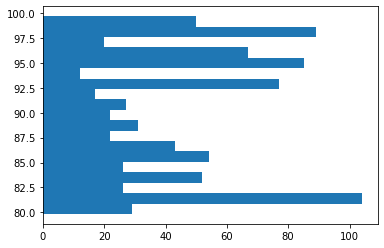

In [58]:
# visualise
new_a = plt.hist(np_str_dist[:, 2], int(max(np_str_dist[:, 2]) - min(np_str_dist[:, 2])), orientation='horizontal')

для опор типа 110 кв желательно разбивать на сегменты по 1м, и выбирать три самых больших - из них самый нижний.

In [59]:
def xarms_levels(array, segment_size):
    segmented = []
    start = min(array)
    end = start + segment_size
    while end < max(array):
        segmented.append(sum(end > i > start for i in array))
        start += segment_size
        end += segment_size

        
    # then choose only bigger than mean *2
    ma = []
    biggest = 0
    biggest_nu = 0
    for nu, i in enumerate(segmented):
        if i > (np.mean(segmented)*1.8):
            ma.append(round((min(array) + segment_size*nu), 1))
        if i > biggest:
            biggest = i
            biggest_nu = nu
    
    big_one = round((min(array) + segment_size*biggest_nu), 1)
    
    return sorted(ma), big_one

In [60]:
def xarms_levels2(array, segment_size):
    segmented = []
    start = min(array)
    end = start + segment_size
    while end < max(array):
        segmented.append(sum(end > i > start for i in array))
        start += segment_size
        end += segment_size

        
    # then choose only bigger than max value*0.4
    ma = []
    biggest = 0
    biggest_nu = 0
    for nu, i in enumerate(segmented):
        if i > max(segmented)*0.4:
            ma.append(round((min(array) + segment_size*nu), 1))
        if i > biggest:
            biggest = i
            biggest_nu = nu
    
    big_one = round((min(array) + segment_size*biggest_nu), 1)
    
    return sorted(ma), big_one

In [61]:
# then group them if they close to each other
def group_arms(levels, segment_size):
    new_levels = [levels[0]]   # add first one
    spam = levels[0]
    for i in range(1, len(levels)):
        if levels[i] == round((spam + segment_size), 1):
            spam = levels[i]
        else:
            new_levels.append(levels[i])
            spam = levels[i]
    
    return new_levels

In [62]:
# try to split xarms
first_run = xarms_levels(np_str_dist[:,2], 1)[0]   # take 1m step
first_run

[80.8, 94.8, 97.8]

In [63]:
first_run = group_arms(first_run, 1)

In [64]:
# cut again - try to get first arm - use -3 as it is 3th from top
np_str_cut_1 = np.delete(np_str_dist, np_str_dist[:,2] < first_run[-3]-0.2, 0)   # bot side
np_str_cut_1 = np.delete(np_str_cut_1, np_str_cut_1[:,2] > first_run[-2], 0)   # top side

In [65]:
# second run - more accurate - 0.1m segments
second_run = xarms_levels(np_str_cut_1[:,2], 0.1)[1]
second_run

81.7

In [66]:
# final cut - low level - 0.3m
np_str_top = np.delete(np_str_dist, np_str_dist[:,2] < second_run-0.3, 0)

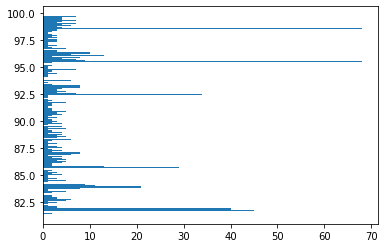

In [67]:
# visualise
new_cut = plt.hist(np_str_top[:, 2], int(max(np_str_top[:, 2]) - min(np_str_top[:, 2]))*10, orientation='horizontal')

In [68]:
np.mean(new_cut[0]), np.average(new_cut[0])

(4.483333333333333, 4.483333333333333)

(1512630.5705000001, 1512635.3994999998, 5365939.9350000005, 5365947.524999999)

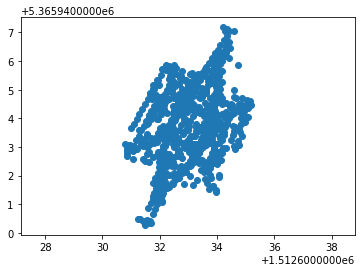

In [69]:
plt.scatter(np_str_top[:,0], np_str_top[:,1])
plt.axis('equal')

In [70]:
# try to find each arm 
third_run = xarms_levels2(np_str_top[:,2], 0.1)[0]
third_run

[81.7, 81.8, 85.7, 92.4, 95.4, 98.5]

In [71]:
num_arms = group_arms(third_run, 0.1)[-3:]
num_arms

[92.4, 95.4, 98.5]

In [28]:
# devide by arms and cut 1.5m from the center
arms = []
for i in range(len(num_arms)):
    arm = np.delete(np_str_top, np_str_top[:,2] < (num_arms[i] - 0.2), 0)   # cut bot
    arm = np.delete(arm, arm[:,2] > (num_arms[i] + 0.2), 0)   # cut top
    arm = np.delete(arm, arm[:,4] < 2, 0)   # cut by len 0 - 2
    arms.append(arm)

In [38]:
# then select by angle 
# devide to 2 part by angle
# find angle and max len for each part

first_part = []
second_part = []

for i in range(len(arms[0])):
    if i != 0:
        if abs(arms[0][:,3][i]-spam) > 40:
            second_part.append(list(arms[0][i]))
        else:
            first_part.append(list(arms[0][i]))
    else:
        spam = arms[0][:,3][i]
        first_part.append(list(arms[0][i]))

print(len(first_part), len(second_part))


3 6


In [39]:
def cutpart(part):
    part = np.array(part)
    part = np.delete(part, part[:,3] > np.mean(part[:,3])+25, 0)   # cut by angle
    part = np.delete(part, part[:,3] < np.mean(part[:,3])-25, 0)   # cut by angle
    part = np.delete(part, part[:,4] < max(part[:,4])-0.5, 0)   # cut -0.2 from end
    
    return part

In [40]:
first_part = cutpart(first_part)
second_part = cutpart(second_part)

In [41]:
first_az, sec_az = np.mean(first_part[:, 3]), np.mean(second_part[:,3])
first_len, sec_len = max(first_part[:, 4]), max(second_part[:,4])
first_h, sec_h = np.mean(sorted(first_part[:, 2])[:5]), np.mean(sorted(second_part[:,2])[:5])

In [42]:
first_h, sec_h

(92.44, 92.4375)

In [43]:
from math import cos, sin, radians

def aztocoords(az, length):
    dx = round(sin(radians(az))*length, 2)
    dy = round(cos(radians(az))*length, 2)
    
    return dx, dy

In [44]:
first_shift = aztocoords(first_az, first_len)
sec_shift = aztocoords(sec_az, sec_len)

In [45]:
st_p = (cpoint.x + first_shift[0], cpoint.y + first_shift[1])
end_p = (cpoint.x + sec_shift[0], cpoint.y + sec_shift[1])

(1512630.3879999998, 1512635.712, 5365939.9350000005, 5365947.524999999)

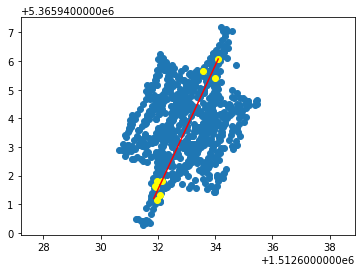

In [51]:
plt.scatter(np_str_cut[:,0], np_str_cut[:,1])
plt.scatter(arms[0][:,0], arms[0][:,1], color='yellow')
#plt.scatter(second_part[:,0], second_part[:,1], color='black')
#plt.scatter(first_part[:,0], first_part[:,1], color='black')
plt.plot([st_p[0], end_p[0]], [st_p[1], end_p[1]], color='red')
plt.axis('equal')

In [47]:
# add z-coords to the axes